## Columns to be removed from training/validation

In [2]:
disqualified_columns = ["tls_joint_isoitu_policy_crt_count", "rdap_time_from_last_change", "lex_www_flag"]

# Load Tensorflow and check GPU availability

In [3]:
import numpy as np
import tensorflow as tf
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import sys

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2024-08-13 20:24:43.762135: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 20:24:43.762200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 20:24:43.791390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 20:24:43.859769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load input datasets

In [4]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pandas import DataFrame
from pandas.core.dtypes import common as com
from pyarrow import Table


def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    '../feature-extraction/floor/benign_2312.parquet',
]
malicious_dataset_filenames = [
    '../feature-extraction/floor/malware_2406_strict.parquet'
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "malware"
# #############################################################



# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}

# print column count
print(f"Benign columns: {len(df_benign.columns)}")
print(f"Malicious columns: {len(df_malicious.columns)}")



# ===================
# AUTO BALANCING !!!
# Subsample benign to match the size of malicious
# df_benign = df_benign.sample(n=len(df_malicious))
# ===================

# Concatentate benign and malicious
df = pd.concat([df_benign, df_malicious])


def cast_timestamp(df: DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)

    return df

df = cast_timestamp(df)

# Handle NaNs
df.fillna(-1, inplace=True)


# SUBSAMPLE (OPTIONAL)
subsample = 1.0 # 1.0 means no subsample
if subsample < 1.0:
    df = df.sample(frac=subsample)

# Drop the domain name column
df.drop("domain_name", axis=1, inplace=True)

# Remove disqualified columns
for column in disqualified_columns:
    if column in df.columns:
        df.drop(column, axis=1, inplace=True)

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

print(f"Total samples: {len(df)}")
print(f"Benign count: {len(df_benign)}")
print(f"Malicious count: {len(df_malicious)}")



Benign columns: 178
Malicious columns: 178
Total samples: 563001
Benign count: 462192
Malicious count: 100809


# Data preprocessing

In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)
features = pd.DataFrame(scaled_data, columns=features.columns)

# Save the scaler
joblib.dump(scaler, "boundaries/malware_general_scaler.joblib")

pd.set_option('display.max_columns', None)

# Train-test split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
  features,
  labels,
  test_size=0.2,
  random_state=42,
  shuffle=True, 
  stratify=labels
)


# Define the NN model

In [7]:
class Net(nn.Module):
    def __init__(self, feature_size):
        super(Net, self).__init__()


        # Adjust the size calculation based on the number of convolutional layers
        self.fc1 = nn.Linear(feature_size, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 1)
        
        # Optionally use dropout
        self.dropout1 = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(F.relu(self.fc2(x)))
        x = self.dropout1(F.relu(self.fc3(x)))

        return self.fc4(x) 


In [8]:
def compute_metrics(data_loader, model):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            true_labels.extend(target.cpu().numpy())
            predictions.extend(torch.sigmoid(output).round().cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return accuracy, f1, predictions, true_labels

In [9]:
import torch.nn.functional as F
import math

def prepare_dataset(X_train, Y_train, X_test, Y_test):

    # Convert data to torch tensors
    x_train = torch.tensor(X_train.values, dtype=torch.float32)
    y_train = torch.tensor(Y_train.values, dtype=torch.long)
    x_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_test = torch.tensor(Y_test.values, dtype=torch.long)

    return x_train, y_train, x_test, y_test


# print feature size

In [31]:
x_train, y_train, x_test, y_test = prepare_dataset(X_train, Y_train, X_test, Y_test)



/home/poli/.cache/pypoetry/virtualenvs/domainradar-training-YTp98ywL-py3.11/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  

# Train the model

In [32]:
from sklearn.utils import class_weight
import torch.optim as optim

# Hyperparameters
LEARNING_RATE = 0.00045
BATCH_SIZE = 512
EPOCHS = 80


# # Calculate class weights
class_weights = {0: 1.0, 1: 1.0} 
weights = torch.tensor([class_weights[1]], dtype=torch.float).to(device)


model = Net(x_train.shape[1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_data = TensorDataset(x_train.to(device), y_train.float().unsqueeze(1).to(device))  # Ensure y_train is float and of shape (batch_size, 1)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = TensorDataset(x_test.to(device), y_test.float().unsqueeze(1).to(device))  # Ensure y_test is float and of shape (batch_size, 1)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

epoch_losses = []
epoch_accuracies = []
epoch_f1s = []


# # Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)  # Move data to the device
        optimizer.zero_grad()
        output = model(data)
        
        # negate the output to match the class weights
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Compute average loss
    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)

    # Evaluate model and store metrics
    train_accuracy, train_f1, _, _ = compute_metrics(train_loader, model)
    epoch_accuracies.append(train_accuracy)
    epoch_f1s.append(train_f1)

    # Enhanced logging
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}")




Epoch 1/80 - Loss: 0.1014, Accuracy: 0.9701, F1 Score: 0.9132
Epoch 2/80 - Loss: 0.0684, Accuracy: 0.9727, F1 Score: 0.9194
Epoch 3/80 - Loss: 0.0626, Accuracy: 0.9754, F1 Score: 0.9312
Epoch 4/80 - Loss: 0.0584, Accuracy: 0.9768, F1 Score: 0.9332
Epoch 5/80 - Loss: 0.0556, Accuracy: 0.9789, F1 Score: 0.9407
Epoch 6/80 - Loss: 0.0532, Accuracy: 0.9798, F1 Score: 0.9431
Epoch 7/80 - Loss: 0.0507, Accuracy: 0.9793, F1 Score: 0.9423
Epoch 8/80 - Loss: 0.0494, Accuracy: 0.9815, F1 Score: 0.9473
Epoch 9/80 - Loss: 0.0472, Accuracy: 0.9814, F1 Score: 0.9473
Epoch 10/80 - Loss: 0.0464, Accuracy: 0.9815, F1 Score: 0.9471
Epoch 11/80 - Loss: 0.0447, Accuracy: 0.9823, F1 Score: 0.9492
Epoch 12/80 - Loss: 0.0432, Accuracy: 0.9828, F1 Score: 0.9515
Epoch 13/80 - Loss: 0.0423, Accuracy: 0.9829, F1 Score: 0.9507
Epoch 14/80 - Loss: 0.0412, Accuracy: 0.9829, F1 Score: 0.9517
Epoch 15/80 - Loss: 0.0405, Accuracy: 0.9827, F1 Score: 0.9519
Epoch 16/80 - Loss: 0.0391, Accuracy: 0.9847, F1 Score: 0.9568
E

# Save the model

In [33]:
# save trained model 
torch.save(model.state_dict(), './models/malware_deep.pth')

# Testing trained model

/tmp/ipykernel_465189/1233453498.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/malware_deep.pth'))


Test Accuracy: 0.9842, Test F1 Score: 0.9553


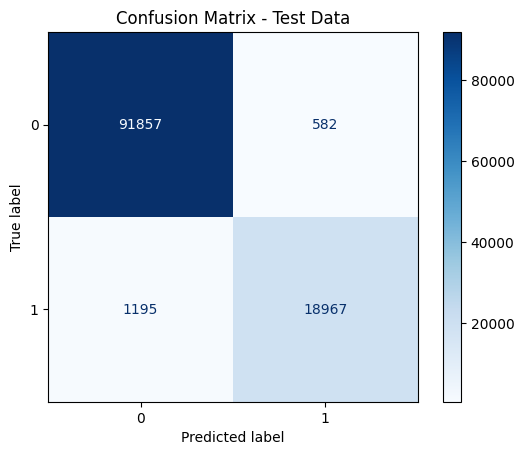

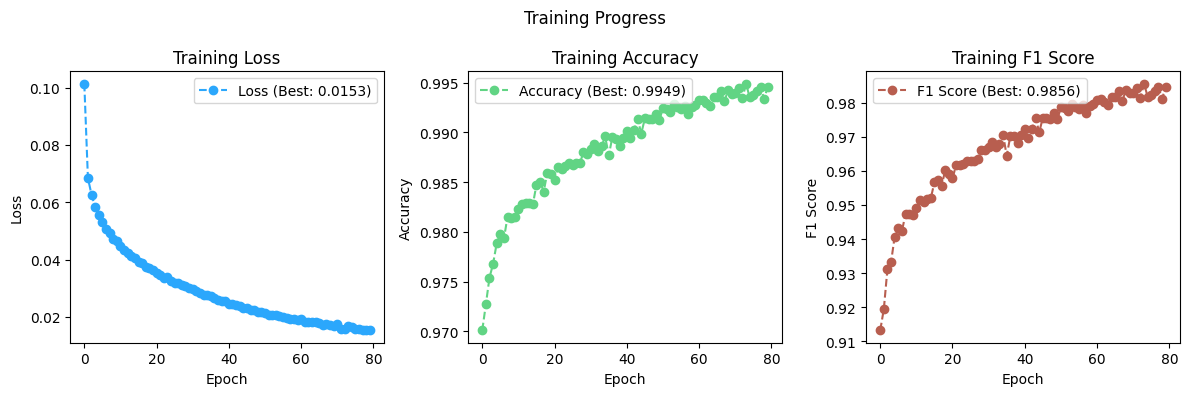

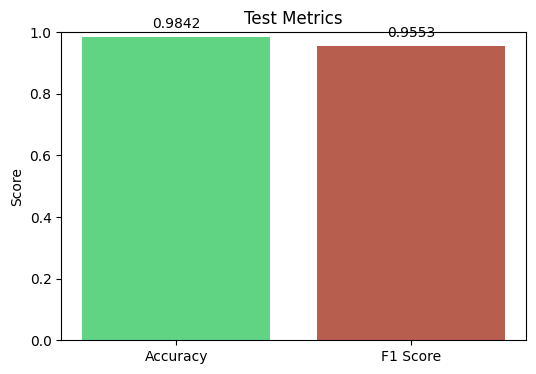

In [34]:
import matplotlib.pyplot as plt


# load model
model = Net(feature_size=173).to(device)
model.load_state_dict(torch.load('./models/malware_deep.pth'))

# Evaluate on the test set
test_accuracy, test_f1, predictions, true_labels = compute_metrics(test_loader, model)
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")

# Plotting the confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Data')
plt.show()

# Plotting the training progress
plt.figure(figsize=(12, 4))

# Plot for Loss
plt.subplot(1, 3, 1)
plt.plot(epoch_losses, linestyle='--', marker='o', color='#2ba7fc', label=f'Loss (Best: {min(epoch_losses):.4f})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot for Accuracy
plt.subplot(1, 3, 2)
plt.plot(epoch_accuracies, linestyle='--', marker='o', color='#61d484', label=f'Accuracy (Best: {max(epoch_accuracies):.4f})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# Plot for F1 Score
plt.subplot(1, 3, 3)
plt.plot(epoch_f1s, linestyle='--', marker='o', color='#b85e4f', label=f'F1 Score (Best: {max(epoch_f1s):.4f})')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training F1 Score')
plt.legend()

plt.suptitle('Training Progress')
plt.tight_layout()
plt.show()

# Plotting the testing results
plt.figure(figsize=(6, 4))

metrics = ['Accuracy', 'F1 Score']
values = [test_accuracy, test_f1]
colors = ['#61d484', '#b85e4f']

plt.bar(metrics, values, color=colors)
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')
plt.ylabel('Score')
plt.title('Test Metrics')
plt.show()

# bylo 2k na 2k


# Validate the model on a separate Validation dataset

torch.Size([2312, 173]) torch.Size([2312])
Accuracy: 0.9987024221453287
Weighted Accuracy: 0.9987024221453287
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
False Positive Rate: 0.0012975778546712802


/tmp/ipykernel_465189/907500591.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/malware_deep.pth'))
/home/poli/.cache/pypoetr

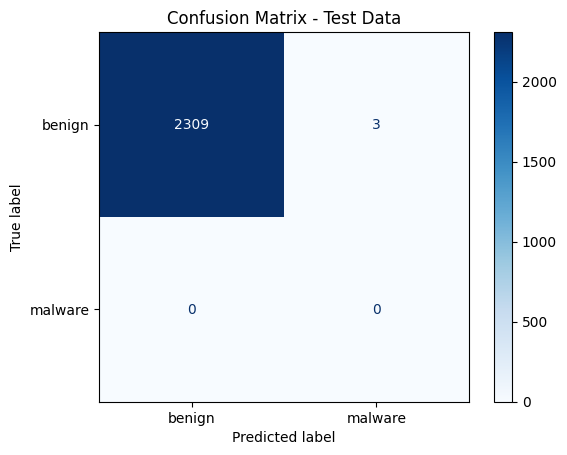

Misclassified domains: ['cnrfps2.joydogames.com', 'www.bohemia-aikikai.cz', 'venerologie.cz']


In [35]:
import pyarrow.parquet as pq
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
from pandas.core.dtypes import common as com
import numpy as np

def cast_timestamp(df: pd.DataFrame):
    """
    Cast timestamp fields to seconds since epoch.
    """
    for col in df.columns:
        if com.is_timedelta64_dtype(df[col]):
            df[col] = df[col].dt.total_seconds()  # This converts timedelta to float (seconds)
        elif com.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype(np.int64) // 10**9  # Converts datetime64 to Unix timestamp (seconds)
    return df

# Load the validation dataset
validation_dataset_filename = '../testdata/validation_malware.parquet'
df_validation = pq.read_table(validation_dataset_filename).to_pandas()

# Cast timestamps and handle NaNs
df_validation = cast_timestamp(df_validation)
df_validation.fillna(-1, inplace=True)

# Remove disqualified columns
for column in disqualified_columns:
    if column in df_validation.columns:
        df_validation.drop(column, axis=1, inplace=True)

# Map the labels
df_validation['label'] = df_validation['label'].map({'benign': 0, 'phishing': 1})

# print number of columns


# Extract features and labels
X_val = df_validation.drop(['label', 'domain_name'], axis=1)
y_val = df_validation['label']

# Load the scaler
scaler = joblib.load("boundaries/malware_general_scaler.joblib")

# Scale the features
y_val = y_val.tolist()
X_val_scaled = scaler.transform(X_val)
# convert to tensor
X_val_scaled = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val)
# convert pandas series y_val to llist

# print shape of X_val_scaled and y_val_tensor

# print number of columns

nan_indices = torch.isnan(y_val_tensor)
X_val_scaled = X_val_scaled[~nan_indices]
y_val_tensor = y_val_tensor[~nan_indices]


# print shape of X_val_scaled and y_val_tensor
print(X_val_scaled.shape, y_val_tensor.shape)



# Load the trained model
model = Net(feature_size=173)
model.load_state_dict(torch.load('./models/malware_deep.pth'))
model.eval()
model.to('cuda:0' if torch.cuda.is_available() else 'cpu')


val_data = TensorDataset(X_val_scaled, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# Function to compute metrics and predictions
def compute_metrics_and_predictions(data_loader, model):
    model.eval()
    true_labels = []
    predictions = []
    probabilities = []

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            true_labels.extend(target.cpu().numpy())
            predictions.extend(torch.sigmoid(output).round().cpu().numpy())


    return true_labels, predictions





# Get predictions and probabilities
test_true_labels, test_predictions= compute_metrics_and_predictions(val_loader, model)

# Calculate metrics
accuracy = accuracy_score(test_true_labels, test_predictions)
weighted_accuracy = (accuracy_score(np.array(test_true_labels) == 0, np.array(test_predictions) == 0) + accuracy_score(np.array(test_true_labels) == 1, np.array(test_predictions) == 1)) / 2
precision = precision_score(test_true_labels, test_predictions)
recall = recall_score(test_true_labels, test_predictions)
f1 = f1_score(test_true_labels, test_predictions)
tn, fp, fn, tp = confusion_matrix(test_true_labels, test_predictions).ravel()
false_positive_rate = fp / (fp + tn)

# Display metrics
print(f'Accuracy: {accuracy}')
print(f'Weighted Accuracy: {weighted_accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'False Positive Rate: {false_positive_rate}')

# Display confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['benign', 'malware'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Data')
plt.show()

# Identify misclassified domain names
misclassified = df_validation.iloc[[i for i, (y_true, y_pred) in enumerate(zip(test_true_labels, test_predictions)) if y_true != y_pred]]
misclassified_domains = misclassified['domain_name'].tolist()
print(f'Misclassified domains: {misclassified_domains}')

# bylo x 1000
# 10 x 


# Make test predictions

In [36]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pyarrow import Table

# Load the model and scaler
model = load_model('dga_binary_model.keras')
scaler = joblib.load("dga_binary_scaler.joblib")

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    '../feature-extraction/floor/benign_2312_anonymized.parquet',
    '../feature-extraction/floor/umbrella_benign_FINISHED.parquet',
]
malicious_dataset_filenames = [
    '../feature-extraction/floor/lex-dga-830k-pick.parquet'
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "dga"
# #############################################################

def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}

# Concatentate benign and malicious
test_df = pd.concat([df_benign, df_malicious])

# Handle NaNs
test_df.fillna(-1, inplace=True)


# Take only N random samples
N = 500
test_df = test_df.sample(n=N, random_state=42)

total_predictions = 0
correct_predictions = 0

for index, row in test_df.iterrows():
    domain_name = row['domain_name']
    original_label = row['label']
    
    # Drop "domain_name" and "label" columns
    feature_vector = pd.DataFrame([row])
    feature_vector.drop(columns=['domain_name', 'label'], inplace=True)

     # Scale the feature vector using the loaded scaler
    scaled_feature_vector = scaler.transform(feature_vector)
    
    # Perform prediction
    prediction = model.predict(scaled_feature_vector, verbose=0)
    
    # Extract the predicted class
    predicted_label = "benign" if prediction < 0.5 else "dga"
    
    # Check if the prediction was correct
    if original_label == predicted_label:
        correct_predictions += 1
    
    total_predictions += 1
    
    # Print the result
    result="WRONG"
    if predicted_label == original_label:
        result="OK"
        
    pred_disp = "!!! DGA !!!"
    if predicted_label == "benign":
        pred_disp = "BENIGN"
        
    
    print(f"{result} | {domain_name} ({original_label}), Predicted: {pred_disp}, Prob: {prediction}")

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")




OSError: No file or directory found at dga_binary_model.keras